> ### EEE4423: Deep Learning Lab

# LAB \#11: Character Generation using LSTM

<h4><div style="text-align: right"> Due date: May 18, 2023. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 2 PM in the form of [ID_Name_Lab11.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-15 13:12:31.716549


In [2]:
!pip install unidecode --user

In [4]:
import unidecode
import string
import random
import re
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

These sorts of generative models form the basis of machine translation, image captioning, question answering and more.

<img src="http://drive.google.com/uc?export=view&id=16E7HG_dCyfTo9u9qrrhp2eClq6xK6-f_" style="width: 600px;"/>

### 1. Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package

<img src="http://drive.google.com/uc?export=view&id=171lX3vxj60AQNScQi872BHx2Rz6J7-3J" />

In [6]:
file = unidecode.unidecode(open('./dataset-dllab/lab11/lose_yourself_eminem.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4063


To make inputs out of this big string of data, we will be splitting it into chunks.

In [140]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ghter
But hold your nose 'cause here goes the cold water
His hoes don't want him no mo, he's cold product
They moved on to the next schmo who flows, he nose dove and sold nada
So the soap opera is told


Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [141]:
# Turn string into list of longs
all_characters = string.printable
print(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print('abcDEF is changed to ', char_tensor('abcDEF'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

abcDEF is changed to  tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [142]:
def random_training_set():    
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

### 2. Build the LSTM model [4 points]

#### [Diagram of LSTM]
<img src="http://drive.google.com/uc?export=view&id=1baQ6Ffu-vDcXbOEBYGeLzhmfvaj4DGgW" style="width: 800px;"/>
LSTM consists of cell state, hidden state and 3 gates that modify or use the cell state. The cell state is the key part of the LSTM and you can think that information "flows" in there. The operation of 3 gates are described in below.

#### [Forget Gate]
The forget gate determines which information in the cell state should be erased.
<img src="http://drive.google.com/uc?export=view&id=1sJisl5P0hggmvH4qrcYgSETFKdFdBSH_" style="width: 600px;"/>

#### [Input Gate]
First, the candidate cell state is created using the current input and the previous hidden state. And the input gate determines how much the candidate cell state is reflected to the cell state.
<img src="http://drive.google.com/uc?export=view&id=1Df-k5FORGH7PnXauYcb8qqUpY3Uot9A7" style="width: 600px;"/>

#### [Output Gate]
The output gate determines which elements should be extracted from the cell state to produce the output.
<img src="http://drive.google.com/uc?export=view&id=1JLCGPcrZLOYfjyJhMTvmfixHq5plFj8L" style="width: 600px;"/>

The above expression is summarized as follows,
<img src="http://drive.google.com/uc?export=view&id=1kGq8DwwzizuNcg6GF0GaP1DAu26FFlrB" style="width: 300px;"/>


This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one LSTM layer that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [550]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        self.encoder = nn.Embedding(input_dim, hidden_dim) #encoder
        
        self.tanh= nn.Tanh()
        self.sigmoid= nn.Sigmoid()
        
        # lstm
        # Weight of x
        self.forget_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.cell_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.output_gate_x = nn.Linear(hidden_dim, hidden_dim)
        
        #Weight of h, I separate weight of X and h for higher performance 
        self.forget_gate_h = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate_h = nn.Linear(hidden_dim, hidden_dim)
        self.cell_gate_h = nn.Linear(hidden_dim, hidden_dim)
        self.output_gate_h= nn.Linear(hidden_dim, hidden_dim)
        
        self.decoder = nn.Linear(hidden_dim, output_dim) #decoder
    
    
    def forward(self, x, hn, cn):
        length= len(x)
        x = self.encoder(x) #encoding
        x = x.view(-1, x.size()[0], x.size()[1]) #match the shape of tensor
        #training each word in x, and accumulate each output to total_output
        total_output = torch.tensor([]).cuda()
        for t in range(length):
            input_x = x[: , t, :] #1, input_dim, hidden_dim
            forget_gate = self.sigmoid(self.forget_gate_x(input_x) + self.forget_gate_h(hn))
            input_gate = self.sigmoid(self.input_gate_x(input_x) + self.input_gate_h(hn))
            cell_gate = self.tanh(self.cell_gate_x(input_x) + self.cell_gate_h(hn)) #tanh
            output = self.sigmoid(self.output_gate_x(input_x) + self.output_gate_h(hn))
        
            cn = forget_gate * cn + input_gate*cell_gate #new cell gate
            hn = output * torch.tanh(cn) #new hidden layer
            output = self.decoder(hn[-1, -1, :]) #match shape of output
            total_output = torch.cat([total_output, output]) #accumulate
        
        total_output = total_output.reshape(length, self.input_dim)
        return total_output, hn, cn

    
    def init_hidden(self):
        # The size of h0, c0 should be (layer_dim, batch_size, hidden_dim)
        # I didn't use layer_dim
        h0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda()) # initial hidden state
        c0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda()) # initial cell state
        return h0, c0
    
hidden_dim = 100
n_layers = 1
n_characters = len(all_characters) #100

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (forget_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (cell_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (output_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (forget_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (cell_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (output_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

### 3. Loss function and optimizer

In [551]:
criterion = nn.CrossEntropyLoss()

lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4 . Write the character level generation code [4 points]

- Generate a sentence with a length of $predict\_len$, starting from a single character $prime\_str$.
- Example) evaluate(prime_str='Y', predict_len=20) -> You better let it go

In [552]:
def evaluate(prime_str='W', predict_len=100):
    # suppose prime_str is a single character
    # and use greedy search to predict the next character
    hn, cn = model.init_hidden()
    predicted = str()
    
    for i in range(predict_len):
        input_tensor = char_tensor(prime_str).cuda() #change word to tensor
        output, hn, cn = model(input_tensor, hn.cuda(), cn.cuda())
        new_char = output.argmax(dim=1).item()
        prime_str = all_characters[new_char] #output becomes next input in loop
        predicted += prime_str
        
        #predicted.append()
        #prime_str = chr(new_char + ord('A'))
        
    return predicted

### 5 . Write the code to train the model [2 points]

- Plot the training loss curve.
- Print the output sentence with a length of 100, using $evaluate()$ function.

************************* epoch100 *************************
loss 2.0480
 the the the the the the the the the the the the the the the the the the the the the the the the the 

************************* epoch200 *************************
loss 1.2039
 moment
You better not one the moment
You better not one the moment
You better not one the moment
Yo 

************************* epoch300 *************************
loss 1.7634
 moment
You only got one shot
You only got one shot
You only got one shot
You only got one shot
You  

************************* epoch400 *************************
loss 1.3399
 word and only get one shot, do not miss your chance to blow
This opportunity comes once to blow
Thi 

************************* epoch500 *************************
loss 1.3356
n the lose your chance to blow
This opportunity comes once in a lifetime you better lose your chance 

************************* epoch600 *************************
loss 0.9856
n one shot
To fortunity comes once in a lifetim

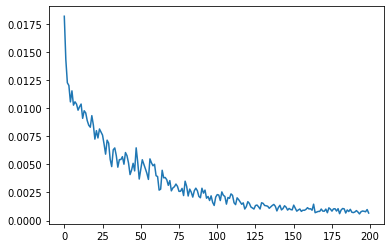

In [553]:
n_epochs = 2000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

hn0, cn0 = model.init_hidden()
hn0, cn0 = hn0.cuda(), cn0.cuda()

for epoch in range(1, n_epochs + 1):
    # Load text
    inputs, targets = random_training_set()
    inputs, targets = inputs.cuda(), targets.cuda()
    if inputs.size()[0] < 200: continue
    
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()
    # Forward pass
    loss = 0
    raw_output, nh, nc = model(inputs, hn0, cn0)
    #print(raw_output)
    loss = criterion(raw_output, targets)
        
    # Backward pass
    loss.backward()
    # Updating parameters
    optimizer.step()
    
    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')
        #print(raw_output)

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

[2] [CS 231n](http://cs231n.stanford.edu/syllabus.html)(http://cs231n.stanford.edu/syllabus.html)

## Discussion

이번 주차에는 LSTM 모델을 구현하였다. LSTM model은 memory cell 개념을 도입하여 long term dependency를 다룰 수 있도록 만든 모델이다. LSTM은 크게 input을 forget_gate, input_gate, cell_gate, output_gate로 나눈 뒤 이들을 다시 activation function을 거쳐 처리하여 output, cn, hn을 추출한다.

foward과정에서는 input으로 들어온 sentence를 한 단어씩 학습시키며 계속 cn, hn을 업데이트 하는 방식으로 모델을 구현하였다. 이 경우 output으로는 word 1개에 대한 100차원의 tensor가 나오게 되는데 이를 누적시켜 문장 전체에 대해, 각 단어별 100차원 tensor를 가지고 있는 최종 output을 만든다.

evaluate는 input으로 한 개의 글자씩을 넣어 나온 output, hn, cn을 다시 input으로 넣는 방식을 통해
greedy한 방식으로 함수를 구성하였다.

이후 학습 부분은 CrossEntropyLoss를 통해 loss를 구하고, 기존의 타 모델들과 동일하게 학습을 진행해주었다.

그 결과 2000번의 epoch를 반복하였을 때 loss를 0.15까지 줄일 수 있었다.
결과 문장의 경우 문장 전체의 흐름이 자연스럽지는 않지만, 실제 노래 가사에서 등장하는
올바른 영단어들의 조합인 문장을 출력하는 것을 확인할 수 있다.